In [1]:
import os
import pandas as pd
import numpy as np
import re
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set working directory here
WD = '/Users/johnmichael/Documents/vm-spinal-risk/vm-spinal-risk'

In [3]:
df = pd.read_csv(os.path.join(WD, 'data/all_risk_processed.csv'))

In [4]:
pat_res_risk = df.iloc[:,24:60]
pat_res_risk = pat_res_risk.drop(['att_check_1','att_check2'], axis=1)
pat_res_risk.columns

Index(['exer_50improv_1drop', 'exer_50improv_10drop', 'exer_50improv_50drop',
       'exer_50improv_90drop', 'exer_90improv_1drop', 'exer_90improv_10drop',
       'exer_90improv_50drop', 'exer_90improv_90drop', 'exer_50pain_1death',
       'exer_50pain_10death', 'exer_50pain_50death', 'exer_90pain_1death',
       'exer_90pain_10death', 'exer_90pain_50death', 'work_50improv_1drop',
       'work_50improv_10drop', 'work_50improv_50drop', 'work_50improv_90drop',
       'work_90improv_1drop', 'work_90improv_10drop', 'work_90improv_50drop',
       'work_50improv_1para', 'work_50improv_10para', 'work_50improv_50para',
       'work_50improv_90para', 'work_90improv_1para', 'work_90improv_10para',
       'work_90improv_50para', 'work_50improv_1death', 'work_50improv_10death',
       'work_50improv_50death', 'work_90improv_1death',
       'work_90improv_10death', 'work_90improv_50death'],
      dtype='object')

In [5]:
# Calculate spinal risk scores
spinal_risk_list = []
split_names = pat_res_risk.columns[0].split("_")
improv_list = []
comp_list = []
comp_type = []

for col in pat_res_risk.columns:
    split_names = col.split("_")
    match_improv = re.search(r'^(\d+)', split_names[1])
    match_comp = re.search(r'^(\d+)(\w+)', split_names[2])
    improv_list.append(float(match_improv.group(1)))
    comp_list.append(float(match_comp.group(1)))
    if match_comp.group(2) == 'drop':
        comp_type.append(1)
    if match_comp.group(2) == 'para':
        comp_type.append(2.304)
    else:
        comp_type.append(2.534)

In [6]:
for index, row in pat_res_risk.iterrows():
    spinal_risk_sum = 0 
    for i in range(len(pat_res_risk.columns)):
        option = 6-row[i]
        col_risk = ((comp_list[i]/option) + (option/improv_list[i]))*comp_type[i]
        spinal_risk_sum += col_risk
    spinal_risk_list.append(spinal_risk_sum)

In [7]:
df['spinal_risk_score'] = spinal_risk_list

In [8]:
df.shape

(802, 86)

In [9]:
corr_df = df.filter(regex='odi_final|spinal_risk_score|dospert').copy().corr()

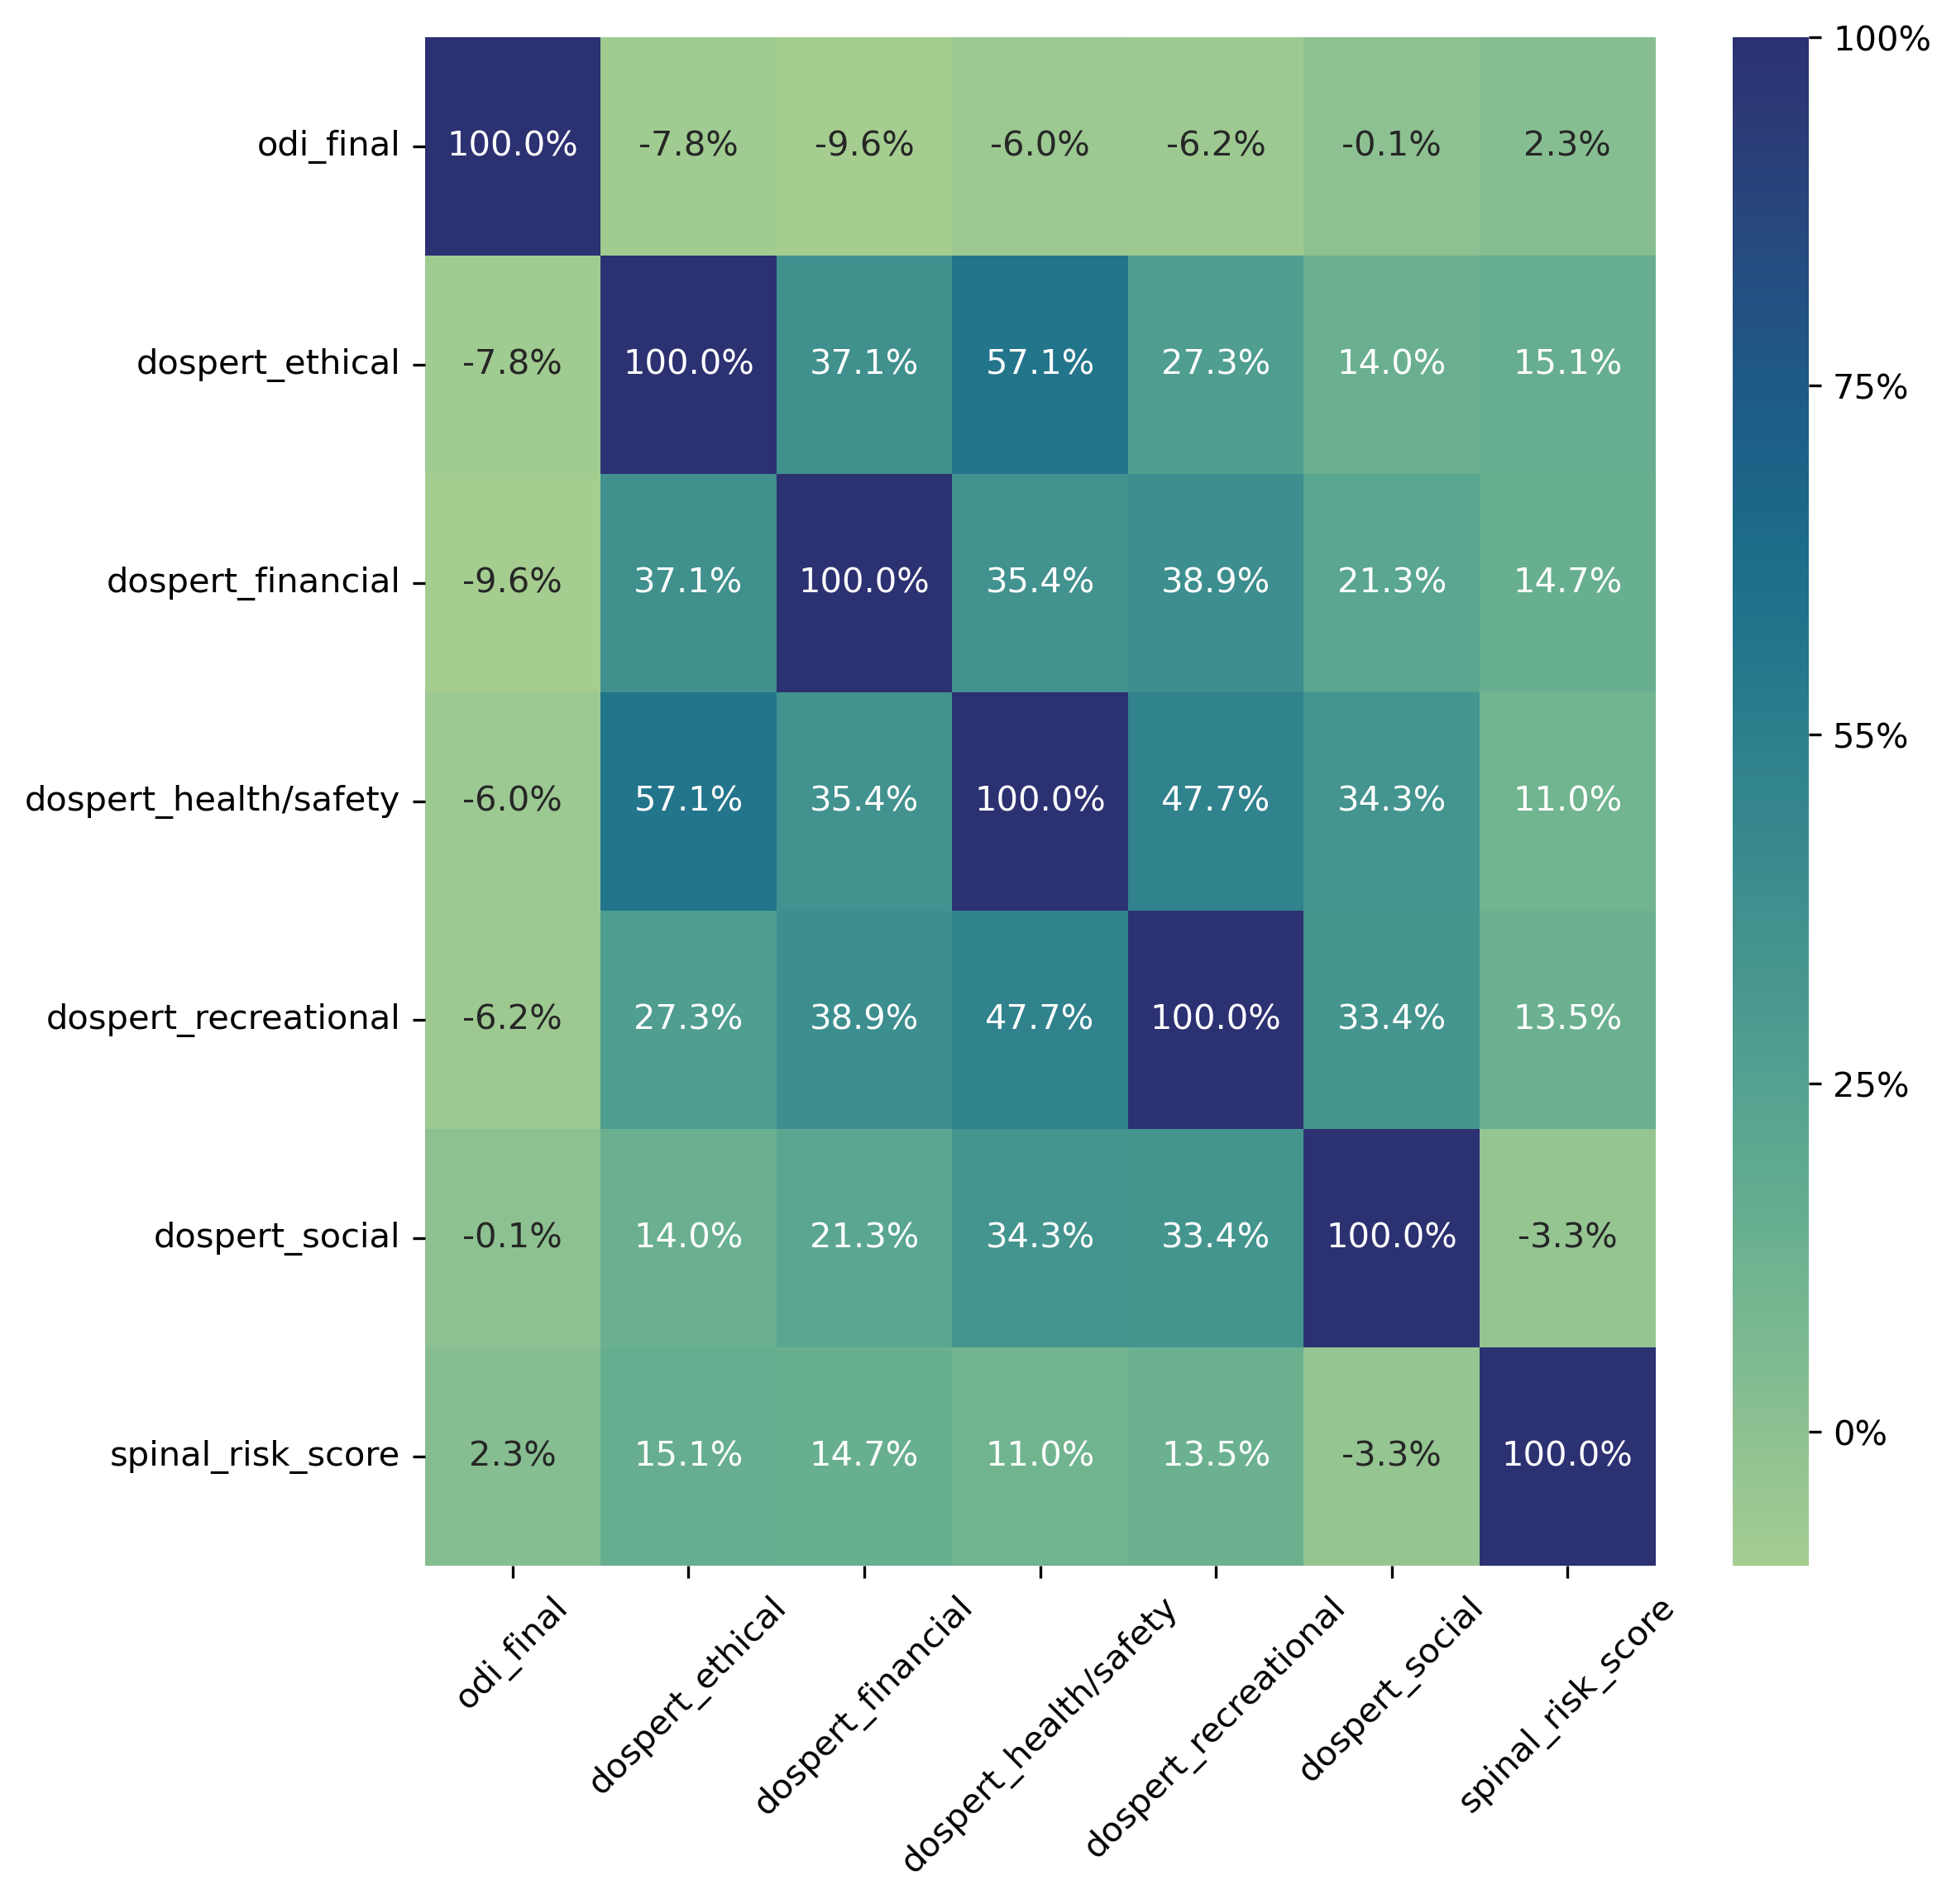

In [10]:
plt.figure(figsize=(8, 8), dpi=300)
ax = sns.heatmap(corr_df, annot=True, cmap='crest', fmt='.1%')
plt.xticks(rotation=45)
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, .25, .5, .75, 1])
cbar.set_ticklabels(['0%', '25%', '55%', '75%', '100%'])
plt.savefig(os.path.join(WD, 'figures/odi_risk_correlation.png'))